In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, rc
from matplotlib.colors import LogNorm, Normalize
from copy import copy
from matplotlib.ticker import FormatStrFormatter, NullFormatter, LogLocator
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
import warnings
from scipy.ndimage import maximum_filter
import matplotlib.path as mpath
import os.path
from roseus_matplotlib import roseus_data
from matplotlib.colors import ListedColormap
roseus = ListedColormap(roseus_data, name='Roseus')
roseus_r = ListedColormap(np.flip(roseus_data, axis=0), name='Roseus')

#### Constant Size

In [2088]:
def brightness_plotter(foldername, filenames, grid_lim_x, grid_lim_y):
    
    cmap = copy(plt.get_cmap('viridis'))
    #cmap.set_under('white', 1.0)  # 1.0 represents not transparent
    cmap2 = copy(plt.get_cmap('plasma_r'))
    cmap2.set_under('white', 1.0)  # 1.0 represents not transparent
    
    rc('text', usetex=True)
    rc('font', size=13)
    rc('legend', fontsize=13)
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

    redshift = 0.05
    beam_x, beam_y, bpa = 5., 5., 0.
    dL = (cosmo.luminosity_distance(redshift).to(u.kpc)).value
    warnings.filterwarnings('ignore')

    density_units = 1e6*0.60364*1.66054e-27
    pressure_units = density_units*3e8**2
    
    # set up plot
    fig, axs = plt.subplots(3, len(filenames), figsize=(12, 13.5))
    fig.subplots_adjust(hspace=0.04, wspace=0)
    
    for i in range(0, len(filenames)):
        sim = np.load(foldername+filenames[0].replace('angle0.frequency0.15 GHz', 'density'))
        x = np.load(filenames[0].split('.')[0]+'.x1.npy')
        y = np.load(filenames[0].split('.')[0]+'.x3.npy')
        X, Y = np.meshgrid(x, y)
        sim2 = np.load(foldername+filenames[i].replace('angle0.frequency0.15 GHz', 'density'))
        x2 = np.load(filenames[i].split('.')[0]+'.x1.npy')
        y2 = np.load(filenames[i].split('.')[0]+'.x3.npy')
        X2, Y2 = np.meshgrid(x2, y2)

        ambient = sim2[:,0,:]
        rawdog = np.min(sim2[:,:,:], axis=1)
        rawdog[rawdog >= ambient*(1 - 1e-6)] = np.max(sim2[:,:,:], axis=1)[rawdog >= ambient*(1 - 1e-6)]
        
        h1 = axs[0,i].pcolormesh(X, Y, np.transpose(sim[:,len(sim[0,:,0])//2,:])*density_units, cmap=roseus, norm=LogNorm(vmin=1e-28, vmax=1e-24), rasterized=True)
        h = axs[0,i].pcolormesh(X2, Y2, np.transpose(rawdog)*density_units, cmap=roseus, norm=LogNorm(vmin=1e-28, vmax=1e-24), rasterized=True)
        
        axs[0,i].set_aspect(1)
        axs[0,i].set_xlim([-120, 120])
        axs[0,i].set_ylim([-170, 170])
        
        if i > 0:
            axs[0,i].set_yticklabels([])
        else:
            axs[0,i].yaxis.set_major_formatter(FormatStrFormatter('%g'))

        axs[0,i].set_xticklabels([])
                    
    cax = fig.add_axes([axs[0,len(filenames) - 1].get_position().x1+0.008,axs[0,len(filenames) - 1].get_position().y0,0.016, \
                        axs[0,len(filenames) - 1].get_position().y1-axs[0,len(filenames) - 1].get_position().y0])
    c = plt.colorbar(h, cax=cax)
    c.set_label(r'Density (kg m$^{-3}$)', labelpad=4)
    cax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    
    # simulation names
    axs[0,0].text(0, 182.5, r'\it{Straight jet}', ha='center', c='black')
    axs[0,1].text(0, 182.5, r'\it{50 Myr period}', ha='center', c='black')
    axs[0,2].text(0, 182.5, r'\it{10 Myr period}', ha='center', c='black')
    axs[0,3].text(0, 182.5, r'\it{2 Myr period}', ha='center', c='black')
    
    # simulation times
    axs[0,0].text(-105, 145, r'$t = $ '+str(13)+' Myr', ha='left', c='dimgrey')
    axs[0,1].text(-105, 145, r'$t = $ '+str(19)+' Myr', ha='left', c='dimgrey')
    axs[0,2].text(-105, 145, r'$t = $ '+str(28)+' Myr', ha='left', c='dimgrey')
    axs[0,3].text(-105, 145, r'$t = $ '+str(40)+' Myr', ha='left', c='dimgrey')
             
    for i in range(0, len(filenames)):
        sim = np.load(foldername+filenames[i])
        x = np.linspace(grid_lim_x[0], grid_lim_x[-1], len(sim[:,0]), endpoint=True)
        y = np.linspace(grid_lim_y[0], grid_lim_y[-1], len(sim[0,:]), endpoint=True)
        X, Y = np.meshgrid(x, y)

        gauss_kernel = Gaussian2DKernel(x_stddev=beam_x*(dL/(1 + redshift)**2)/(3600*180/np.pi)/(2*np.sqrt(2*np.log(2)))/(x[1] - x[0]), \
                                    y_stddev=beam_y*(dL/(1 + redshift)**2)/(3600*180/np.pi)/(2*np.sqrt(2*np.log(2)))/(y[1] - y[0]), \
                                    theta=bpa*np.pi/180.) # pixels
        surface_brightness = np.transpose(convolve(sim[:,:], gauss_kernel)/(1 + redshift)**2)

        cropped = surface_brightness.copy()
        cropped[cropped <= 0.01] = 0
        h = axs[1,i].pcolormesh(X, Y, cropped, cmap=cmap, norm=LogNorm(vmin=0.3, vmax=100), rasterized=True)

        axs[1,i].contourf(X, Y, surface_brightness, levels=0.1*10**np.array([-2,0.5]), colors='w', linewidths=0.2)
        axs[1,i].contour(X, Y, surface_brightness, levels=0.1*10**np.arange(0,10,0.5), colors='w', linewidths=0.2)
        axs[1,i].contour(X, Y, surface_brightness, levels=0.1*10**np.arange(0.25,10,0.5), colors='w', linewidths=0.1)

        sim6 = np.load(foldername+filenames[i].replace('0.15 GHz', '6.0 GHz'))
        surface_brightness6 = np.transpose(convolve(sim6[:,:], gauss_kernel)/(1 + redshift)**2)
        axs[1,i].contour(X, Y, surface_brightness6*Y/np.abs(Y), \
                         levels=np.nanmax(surface_brightness6[Y > 0])*10**np.array([-0.25,-0.125]), colors='r', linewidths=0.4, zorder=1000)
        axs[1,i].contour(X, Y, surface_brightness6*-Y/np.abs(Y), \
                         levels=np.nanmax(surface_brightness6[Y < 0])*10**np.array([-0.25,-0.125]), colors='r', linewidths=0.4, zorder=1000)

        axs[1,i].set_aspect(1)
        axs[1,i].set_xlim([-120, 120])
        axs[1,i].set_ylim([-170, 170])
        
        if i > 0:
            axs[1,i].set_yticklabels([])
        else:
            axs[1,i].yaxis.set_major_formatter(FormatStrFormatter('%g'))

        axs[1,i].set_xticklabels([])
                    
    cax = fig.add_axes([axs[1,len(filenames) - 1].get_position().x1+0.008,axs[1,len(filenames) - 1].get_position().y0,0.016, \
                        axs[1,len(filenames) - 1].get_position().y1-axs[1,len(filenames) - 1].get_position().y0])
    c = plt.colorbar(h, cax=cax)
    cax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    c.set_label(r'S$_{150}$ (mJy beam$^{-1}$)', labelpad=14)
    
    for i in range(0, len(filenames)):
        sim = np.load(foldername+filenames[i].replace('0.15 GHz', '1.4 GHz'))
        x = np.linspace(grid_lim_x[0], grid_lim_x[-1], len(sim[:,0]), endpoint=True)
        y = np.linspace(grid_lim_y[0], grid_lim_y[-1], len(sim[0,:]), endpoint=True)
        X, Y = np.meshgrid(x, y)
        
        gauss_kernel = Gaussian2DKernel(x_stddev=beam_x*(dL/(1 + redshift)**2)/(3600*180/np.pi)/(2*np.sqrt(2*np.log(2)))/(x[1] - x[0]), \
                                    y_stddev=beam_y*(dL/(1 + redshift)**2)/(3600*180/np.pi)/(2*np.sqrt(2*np.log(2)))/(y[1] - y[0]), \
                                    theta=bpa*np.pi/180.) # pixels
        surface_brightness = convolve(sim[:,:], gauss_kernel)/(1 + redshift)**2
        
        sim2 = np.load(foldername+filenames[i].replace('0.15 GHz', '6.0 GHz'))
        surface_brightness2 = convolve(sim2[:,:], gauss_kernel)/(1 + redshift)**2

        alpha = -np.log(np.transpose(surface_brightness2)/np.transpose(surface_brightness))/np.log(6000./1400.)
        alpha[np.transpose(surface_brightness2) <= 0.001] = 0
        h = axs[2,i].pcolormesh(X, Y, alpha, cmap=cmap2, norm=Normalize(vmin=0.6, vmax=0.7), rasterized=True)
        
        axs[2,i].contourf(X, Y, np.transpose(surface_brightness2), levels=0.01*10**np.array([-2,0.5]), colors='w', linewidths=0.2)

        axs[2,i].set_aspect(1)
        axs[2,i].set_xlim([-120, 120])
        axs[2,i].set_ylim([-170, 170])
        
        if i > 0:
            axs[2,i].set_yticklabels([])
        else:
            axs[2,i].yaxis.set_major_formatter(FormatStrFormatter('%g'))
        axs[2,i].set_xticks([-100, -50, 0, 50, 100])
        axs[2,i].xaxis.set_major_formatter(FormatStrFormatter('%g'))

    cax = fig.add_axes([axs[2,len(filenames) - 1].get_position().x1+0.008, \
                        axs[2,len(filenames) - 1].get_position().y0,0.016,axs[2,len(filenames) - 1].get_position().y1-axs[2,len(filenames) - 1].get_position().y0])
    c = plt.colorbar(h, cax=cax)
    c.set_label(r'$\alpha^{1400}_{6000}$', labelpad=8.5)
    cax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    c.set_ticks([0.6, 0.62, 0.64, 0.66, 0.68, 0.7])
   
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(r'Minor axis (kpc)', labelpad=2.5)
    plt.ylabel(r'Jet axis (kpc)', labelpad=5)
    
    return fig

In [7]:
foldername = 'fixed_size/'
filenames = ['Straight Jet.age13.0.angle0.frequency0.15 GHz.npy', '50 Myr.age19.0.angle0.frequency0.15 GHz.npy', \
             '10 Myr.age28.0.angle0.frequency0.15 GHz.npy', '2 Myr.age40.0.angle0.frequency0.15 GHz.npy']
grid_lim_x = (-100, 100)
grid_lim_y = (-250, 250)

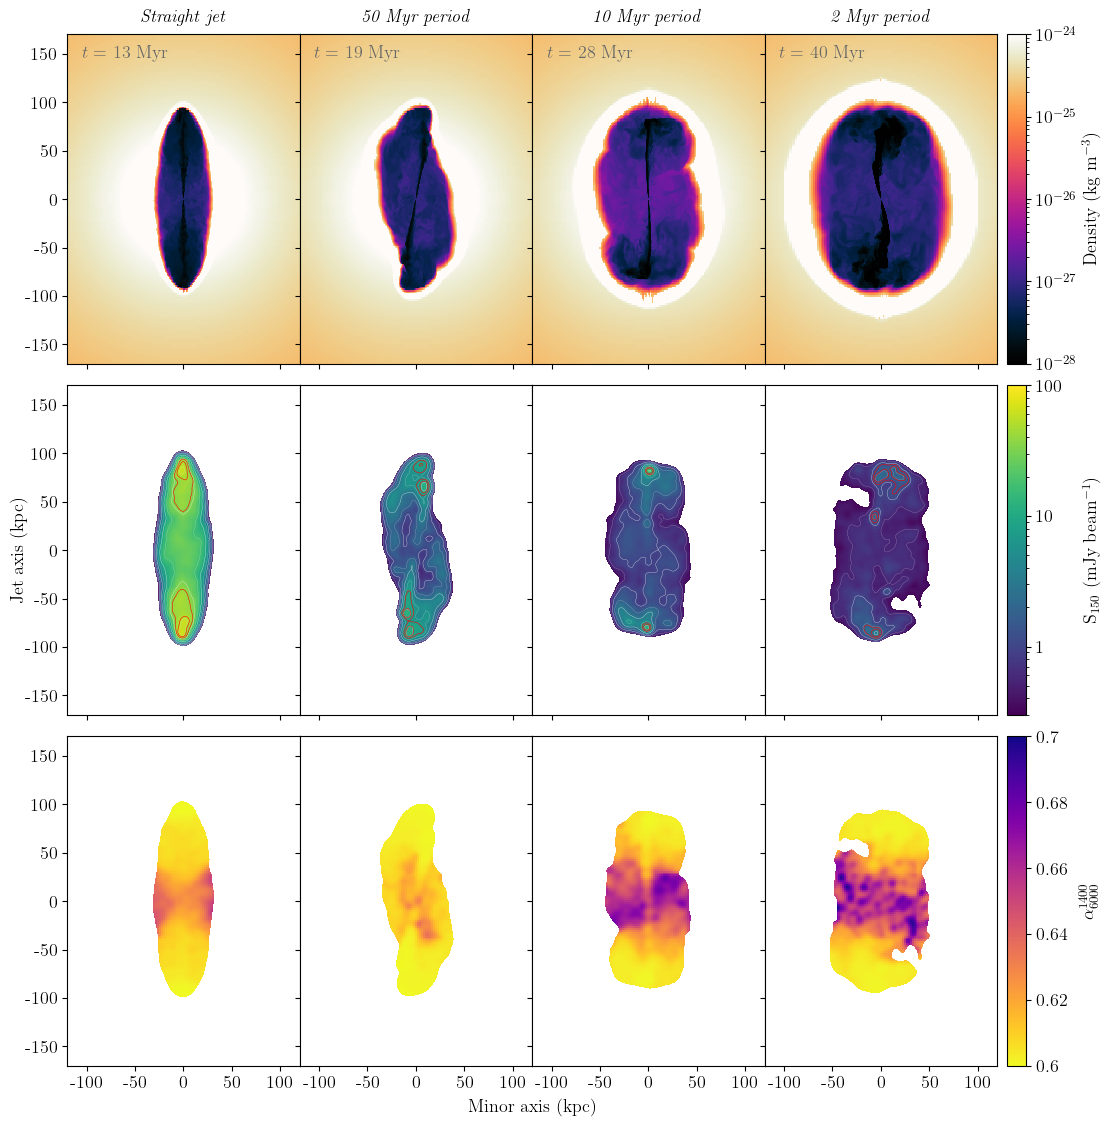

In [2090]:
fig = brightness_plotter(foldername, filenames, grid_lim_x, grid_lim_y)

In [2091]:
fig.savefig('constant_size.pdf')

#### Anti/Symmetric Component Analysis

In [2]:
from scipy import ndimage

def symmetry_component_analysis(angles, surface_brightness, sensitivity, gauss_kernel, nsamples):

    # create array for results
    result1 = np.zeros((nsamples, len(angles)))
    result2 = np.zeros((nsamples, len(angles)))
    result3 = np.zeros((nsamples, len(angles)))

    # calculate dimensions of beam in pixels
    if isinstance(sensitivity, (list, np.ndarray)):
        x_stddev = [gauss_kernel[0].__dict__['_model'].__dict__['x_stddev'].value, gauss_kernel[1].__dict__['_model'].__dict__['x_stddev'].value]
        y_stddev = [gauss_kernel[0].__dict__['_model'].__dict__['y_stddev'].value, gauss_kernel[1].__dict__['_model'].__dict__['y_stddev'].value]
        pixels_per_beam = [np.pi*x_stddev[0]*y_stddev[0]*(2*np.log(2)), np.pi*x_stddev[1]*y_stddev[1]*(2*np.log(2))]
    else:
        x_stddev = gauss_kernel.__dict__['_model'].__dict__['x_stddev'].value
        y_stddev = gauss_kernel.__dict__['_model'].__dict__['y_stddev'].value
        pixels_per_beam = np.pi*x_stddev*y_stddev*(2*np.log(2))

    # create rotated images for each angle tested
    if isinstance(sensitivity, (list, np.ndarray)):
        rot_img1 = np.zeros((len(angles), len(surface_brightness[0][:,0]), len(surface_brightness[0][0,:])))    
        rot_img2 = np.zeros((len(angles), len(surface_brightness[1][:,0]), len(surface_brightness[1][0,:])))    
        for i in range(0, len(angles)):
            # rotate surface brightness image
            rot_img1[i,:,:] = ndimage.rotate(np.nan_to_num(surface_brightness[0][:,:], copy=True, nan=0.), angles[i], reshape=False, order=3)
            rot_img2[i,:,:] = ndimage.rotate(np.nan_to_num(surface_brightness[1][:,:], copy=True, nan=0.), angles[i], reshape=False, order=3)
    else:
        rot_img = np.zeros((len(angles), len(surface_brightness[:,0]), len(surface_brightness[0,:])))    
        for i in range(0, len(angles)):
            # rotate surface brightness image
            rot_img[i,:,:] = ndimage.rotate(np.nan_to_num(surface_brightness, copy=True, nan=0.), angles[i], reshape=False, order=3)
        
    # calculate symmetry axis for MC realisations of survey noise 
    for i in range(0, nsamples):
        # create noise maps to impose on to of rotated images
        if isinstance(sensitivity, (list, np.ndarray)):
            nse_img1 = convolve(np.random.normal(loc=0., scale=sensitivity[0]/10**0.5*np.sqrt(pixels_per_beam[0]), \
                                 size=(len(surface_brightness[0][:,0]), len(surface_brightness[0][0,:]))), gauss_kernel[0])            
            nse_img2 = convolve(np.random.normal(loc=0., scale=sensitivity[1]/10**0.5*np.sqrt(pixels_per_beam[1]), \
                                 size=(len(surface_brightness[1][:,0]), len(surface_brightness[1][0,:]))), gauss_kernel[1])  
        else:
            nse_img = convolve(np.random.normal(loc=0., scale=sensitivity/10**0.5*np.sqrt(pixels_per_beam), \
                                 size=(len(surface_brightness[:,0]), len(surface_brightness[0,:]))), gauss_kernel)

        for j in range(0, len(angles)):
            # calculate MC realisation of radio image
            if isinstance(sensitivity, (list, np.ndarray)):
                image1 = rot_img1[j,:,:] + nse_img1
                image2 = rot_img2[j,:,:] + nse_img2
                image = np.maximum(0, np.minimum(1/0.5, np.nan_to_num(1./(-np.log(image2/image1)/np.log(6000./1400.))))) # 1/alpha
            else:
                image = rot_img[j,:,:] + nse_img
            
            # create binary matrix based on whether pixel is detectable
            detectable = np.zeros_like(image).astype(np.int_)
            if isinstance(sensitivity, (list, np.ndarray)):
                detectable[np.logical_and(image1 >= sensitivity[0], image2 >= sensitivity[1])] = 1
            else:
                detectable[image >= sensitivity] = 1
    
            # calculate detectable pixels each side of axis, and their brightness moments
            left = np.sum(detectable[:,:len(image[0,:])//2], axis=1)
            right = np.sum(detectable[:,(len(image[0,:]) + 1)//2:], axis=1)        
            leftb = np.sum(image[:,:len(image[0,:])//2]*detectable[:,:len(image[0,:])//2], axis=1)
            rightb = np.sum(image[:,(len(image[0,:]) + 1)//2:]*detectable[:,(len(image[0,:]) + 1)//2:], axis=1)      
            leftbb = np.sum(image[:,:len(image[0,:])//2]**2*detectable[:,:len(image[0,:])//2], axis=1)
            rightbb = np.sum(image[:,(len(image[0,:]) + 1)//2:]**2*detectable[:,(len(image[0,:]) + 1)//2:], axis=1)  

            # calculate symmetry index and brightness symmetry index
            result1[i,j] = np.sum((left - right)**2*(left + right))/np.sum(left + right)
            result2[i,j] = np.sum((leftb - rightb)**2*(leftb + rightb))/np.sum(leftb + rightb)
            result3[i,j] = np.sum((leftbb - rightbb)**2*(leftbb + rightbb))/np.sum(leftbb + rightbb)
        
    # find the best fit for each MC realisation
    idx1 = np.argmin(result1, axis=1)
    idx2 = np.argmin(result2, axis=1)
    idx3 = np.argmin(result3, axis=1)

    # find the mean and standard deviation of each symmetry axis
    angle1, dangle1 = np.mean(angles[idx1]), np.std(angles[idx1])
    angle2, dangle2 = np.mean(angles[idx2]), np.std(angles[idx2])
    angle3, dangle3 = np.mean(angles[idx3]), np.std(angles[idx3])
    
    return [angle1, dangle1], [angle2, dangle2], [angle3, dangle3]

#### Precession Statistics

In [2125]:
def symmetry_plotter(foldername, filenames, grid_lim_x, grid_lim_y, redshift, freq='150MHz'):

    # define custom colormaps
    cmap = copy(plt.get_cmap('viridis'))
    #cmap.set_under('white', 1.0)  # 1.0 represents not transparent
    cmap2 = copy(plt.get_cmap('plasma_r'))
    cmap2.set_under('white', 1.0)  # 1.0 represents not transparent
    
    rc('text', usetex=True)
    rc('font', size=13)
    rc('legend', fontsize=13)
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

    # define potential angles for jet axis
    angles = np.arange(-40, 40, 0.01)
    symm_axis = np.arange(-250,250+1e-9,1)

    # create file to store fitted symmetry axes
    if foldername == 'angles_ages/2_myr/':
        if freq == '150MHz':
            df_filename = '2_myr_150MHz_z={:.2f}.csv'.format(redshift)
        elif freq == '1400MHz':
            df_filename = '2_myr_1400MHz_z={:.2f}.csv'.format(redshift)
        else:
            df_filename = '2_myr_alpha_z={:.2f}.csv'.format(redshift)            
        kf_filename = '2_myr_krause_z={:.2f}.csv'.format(redshift)
    if foldername == 'angles_ages/10_myr/':
        if freq == '150MHz':
            df_filename = '10_myr_150MHz_z={:.2f}.csv'.format(redshift)
        elif freq == '1400MHz':
            df_filename = '10_myr_1400MHz_z={:.2f}.csv'.format(redshift)
        else:
            df_filename = '10_myr_alpha_z={:.2f}.csv'.format(redshift)            
        kf_filename = '10_myr_krause_z={:.2f}.csv'.format(redshift)
    if foldername == 'angles_ages/50_myr/':
        if freq == '150MHz':
            df_filename = '50_myr_150MHz_z={:.2f}.csv'.format(redshift)
        elif freq == '1400MHz':
            df_filename = '50_myr_1400MHz_z={:.2f}.csv'.format(redshift)
        else:
            df_filename = '50_myr_alpha_z={:.2f}.csv'.format(redshift)            
        kf_filename = '50_myr_krause_z={:.2f}.csv'.format(redshift)
    if foldername == 'angles_ages/straight/':
        if freq == '150MHz':
            df_filename = 'straight_150MHz_z={:.2f}.csv'.format(redshift)
        elif freq == '1400MHz':
            df_filename = 'straight_1400MHz_z={:.2f}.csv'.format(redshift)
        else:
            df_filename = 'straight_alpha_z={:.2f}.csv'.format(redshift)            
        kf_filename = 'straight_krause_z={:.2f}.csv'.format(redshift)
    if os.path.isfile(df_filename):
        df = pd.read_csv(df_filename, header=0, index_col=0)
    else:
        df = pd.DataFrame(columns=['angle1', 'dangle1', 'angle2', 'dangle2', 'angle3', 'dangle3'])
    if os.path.isfile(kf_filename):
        kf = pd.read_csv(kf_filename, header=0, index_col=0)
    
    # define beam properties
    beam_x, beam_y, bpa = 5., 5., 0.
    dL = (cosmo.luminosity_distance(redshift).to(u.kpc)).value
    warnings.filterwarnings('ignore')

    if foldername == 'angles_ages/straight/':
        fig, axs = plt.subplots(1, 4, figsize=(12, 6.05))
        fig.subplots_adjust(hspace=0, wspace=0)
    elif foldername == 'angles_ages/50_myr/':
        fig, axs = plt.subplots(2, 4, figsize=(12, 11.075))
        fig.subplots_adjust(hspace=0, wspace=0)
    else:
        fig, axs = plt.subplots(4, 4, figsize=(12, 17.1))
        fig.subplots_adjust(hspace=0, wspace=0)
    
    for i in range(0, len(filenames)):
        # read in primary frequency radio image
        if freq == '150MHz':
            sim = np.load(foldername+filenames[i])
            rms = 0.1
        else:
            sim = np.load(foldername+filenames[i].replace('0.15 GHz', '1.4 GHz'))
            rms = 0.01
        x = np.linspace(grid_lim_x[0], grid_lim_x[-1], len(sim[:,0]), endpoint=True)
        y = np.linspace(grid_lim_y[0], grid_lim_y[-1], len(sim[0,:]), endpoint=True)
        X, Y = np.meshgrid(x, y)

        # convolve primary frequency image with gaussian beam for redshift (cannot be less than z=0.05)
        gauss_kernel = Gaussian2DKernel(x_stddev=beam_x*(dL/(1 + redshift)**2)/(3600*180/np.pi)/(2*np.sqrt(2*np.log(2)))/(x[1] - x[0]), \
                                    y_stddev=beam_y*(dL/(1 + redshift)**2)/(3600*180/np.pi)/(2*np.sqrt(2*np.log(2)))/(y[1] - y[0]), \
                                    theta=bpa*np.pi/180.) # pixels
        surface_brightness = np.transpose(convolve(sim[:,:], gauss_kernel)/(1 + redshift)**2)
        cropped = surface_brightness.copy()
        cropped[cropped <= 0.1*rms] = 0

        # convolve secondary frequency image with gaussian beam for redshift
        sim6 = np.load(foldername+filenames[i].replace('0.15 GHz', '6.0 GHz'))
        surface_brightness6 = np.transpose(convolve(sim6[:,:], gauss_kernel)/(1 + redshift)**2)

        # calculate spectra index
        alpha = -np.log(surface_brightness6/surface_brightness)/np.log(6000./1400.)
        alpha[surface_brightness6 <= 0.1*rms] = 0
        
        # calculate symmetry axes at primary frequency (or spectral index)
        if os.path.isfile(df_filename):
            angle1, angle2, angle3 = [df.iloc[i,0], df.iloc[i,1]], [df.iloc[i,2], df.iloc[i,3]], [df.iloc[i,4], df.iloc[i,5]]
        else:
            if freq == '150MHz' or freq == '1400MHz':
                angle1, angle2, angle3 = symmetry_component_analysis(angles, surface_brightness, rms*10**0.5, gauss_kernel, 100)
            else:
                angle1, angle2, angle3 = symmetry_component_analysis(angles, [surface_brightness, surface_brightness6], \
                                                                     [rms*10**0.5, rms*10**0.5], [gauss_kernel, gauss_kernel], 100)
            df.loc[len(df.index)] = [angle1[0], angle1[1], angle2[0], angle2[1], angle3[0], angle3[1]]

        # create plot of simulation with symmetry axes and jet signatures
        if foldername == 'angles_ages/straight/':
            if freq == '150MHz' or freq == '1400MHz':
                h = axs[i%4].pcolormesh(X, Y, cropped, cmap=cmap, norm=LogNorm(vmin=3*rms, vmax=1000*rms), rasterized=True)
            else:
                h = axs[i%4].pcolormesh(X, Y, alpha, cmap=cmap2, norm=LogNorm(vmin=0.6, vmax=0.9), rasterized=True)

            axs[i%4].contourf(X, Y, surface_brightness, levels=rms*10**np.array([-2,0.5]), colors='w', linewidths=0.2)
            if freq == '150MHz' or freq == '1400MHz':
                axs[i%4].contour(X, Y, surface_brightness, levels=rms*10**np.arange(0,10,0.5), colors='w', linewidths=0.2)
                axs[i%4].contour(X, Y, surface_brightness, levels=rms*10**np.arange(0.25,10,0.5), colors='w', linewidths=0.1)

            if freq == '150MHz' or freq == '1400MHz':
                axs[i%4].contour(X, Y, surface_brightness6, \
                             levels=np.nanmax(surface_brightness6)*10**np.array([-0.25,-0.125]), colors='r', linewidths=0.4, zorder=1000)
            else:
                axs[i%4].contour(X, Y, surface_brightness6, \
                             levels=np.nanmax(surface_brightness6)*10**np.array([-0.25,-0.125]), colors='w', linewidths=0.4, zorder=1000)
            
            axs[i%4].scatter(symm_axis/np.tan((angle1[0] + 90)*np.pi/180.), symm_axis, s=0.49, marker='s', color='deeppink', \
                               alpha=np.minimum(1, np.abs(symm_axis/240)), linewidth=0, zorder=2000)
            axs[i%4].scatter(symm_axis/np.tan((angle2[0] + 90)*np.pi/180.), symm_axis, s=0.49, marker='s', color='darkviolet', \
                               alpha=np.minimum(1, np.abs(symm_axis/240)), linewidth=0, zorder=2000)
            axs[i%4].scatter(symm_axis/np.tan((angle3[0] + 90)*np.pi/180.), symm_axis, s=0.49, marker='s', color='midnightblue', \
                               alpha=np.minimum(1, np.abs(symm_axis/240)), linewidth=0, zorder=2000)

            axs[i%4].text(110, -195, r'SI$_0$ = {:.1f}\,$\pm$\,{:.1f}$^\circ$'.format(angle1[0], angle1[1]), \
                               ha='right', c='deeppink', fontsize=8)
            axs[i%4].text(110, -210, r'SI$_1$ = {:.1f}\,$\pm$\,{:.1f}$^\circ$'.format(angle2[0], angle2[1]), \
                               ha='right', c='darkviolet', fontsize=8)
            axs[i%4].text(110, -225, r'SI$_2$ = {:.1f}\,$\pm$\,{:.1f}$^\circ$'.format(angle3[0], angle3[1]), \
                               ha='right', c='midnightblue', fontsize=8)
        else:
            if freq == '150MHz' or freq == '1400MHz':
                h = axs[i//4,i%4].pcolormesh(X, Y, cropped, cmap=cmap, norm=LogNorm(vmin=3*rms, vmax=1000*rms), rasterized=True)
            else:
                h = axs[i//4,i%4].pcolormesh(X, Y, alpha, cmap=cmap2, norm=LogNorm(vmin=0.6, vmax=0.9), rasterized=True)

            axs[i//4,i%4].contourf(X, Y, surface_brightness, levels=rms*10**np.array([-2,0.5]), colors='w', linewidths=0.2)
            if freq == '150MHz' or freq == '1400MHz':
                axs[i//4,i%4].contour(X, Y, surface_brightness, levels=rms*10**np.arange(0,10,0.5), colors='w', linewidths=0.2)
                axs[i//4,i%4].contour(X, Y, surface_brightness, levels=rms*10**np.arange(0.25,10,0.5), colors='w', linewidths=0.1)

            if freq == '150MHz' or freq == '1400MHz':
                axs[i//4,i%4].contour(X, Y, surface_brightness6, \
                             levels=np.nanmax(surface_brightness6)*10**np.array([-0.25,-0.125]), colors='r', linewidths=0.4, zorder=1000)
            else:
                axs[i//4,i%4].contour(X, Y, surface_brightness6, \
                             levels=np.nanmax(surface_brightness6)*10**np.array([-0.25,-0.125]), colors='w', linewidths=0.4, zorder=1000)
            
            axs[i//4,i%4].scatter(symm_axis/np.tan((angle1[0] + 90)*np.pi/180.), symm_axis, s=0.49, marker='s', color='deeppink', \
                               alpha=np.minimum(1, np.abs(symm_axis/170)), linewidth=0, zorder=2000)
            axs[i//4,i%4].scatter(symm_axis/np.tan((angle2[0] + 90)*np.pi/180.), symm_axis, s=0.49, marker='s', color='darkviolet', \
                               alpha=np.minimum(1, np.abs(symm_axis/170)), linewidth=0, zorder=2000)
            axs[i//4,i%4].scatter(symm_axis/np.tan((angle3[0] + 90)*np.pi/180.), symm_axis, s=0.49, marker='s', color='midnightblue', \
                               alpha=np.minimum(1, np.abs(symm_axis/170)), linewidth=0, zorder=2000)

            if foldername == 'angles_ages/50_myr/':
                axs[i//4,i%4].text(108, -175, r'SI$_0$ = {:.1f}\,$\pm$\,{:.1f}$^\circ$'.format(angle1[0], angle1[1]), \
                                   ha='right', c='deeppink', fontsize=8)
                axs[i//4,i%4].text(108, -190, r'SI$_1$ = {:.1f}\,$\pm$\,{:.1f}$^\circ$'.format(angle2[0], angle2[1]), \
                                   ha='right', c='darkviolet', fontsize=8)
                axs[i//4,i%4].text(108, -205, r'SI$_2$ = {:.1f}\,$\pm$\,{:.1f}$^\circ$'.format(angle3[0], angle3[1]), \
                                   ha='right', c='midnightblue', fontsize=8)
            else:
                axs[i//4,i%4].text(108, -125, r'SI$_0$ = {:.1f}\,$\pm$\,{:.1f}$^\circ$'.format(angle1[0], angle1[1]), \
                                   ha='right', c='deeppink', fontsize=8)
                axs[i//4,i%4].text(108, -140, r'SI$_1$ = {:.1f}\,$\pm$\,{:.1f}$^\circ$'.format(angle2[0], angle2[1]), \
                                   ha='right', c='darkviolet', fontsize=8)
                axs[i//4,i%4].text(108, -155, r'SI$_2$ = {:.1f}\,$\pm$\,{:.1f}$^\circ$'.format(angle3[0], angle3[1]), \
                                   ha='right', c='midnightblue', fontsize=8)
            
            if os.path.isfile(kf_filename):
                string = ''
                if kf.iloc[i,0] == 1:
                    string = string + 'C'
                if kf.iloc[i,1] == 1:
                    string = string + 'E'
                if kf.iloc[i,2] == 1:
                    string = string + 'R'
                if kf.iloc[i,3] == 1:
                    string = string + 'S'
                if foldername == 'angles_ages/50_myr/':
                    axs[i//4,i%4].text(-105, -205, r'{:}\,'.format(string), ha='left', c='indigo', fontsize=10)
                else:
                    axs[i//4,i%4].text(-105, -155, r'{:}\,'.format(string), ha='left', c='indigo', fontsize=10)

        # set axes limits and tick marks
        if foldername == 'angles_ages/straight/':
            axs[i%4].set_aspect(1)
            axs[i%4].set_xlim([-120, 120])
            axs[i%4].set_ylim([-240, 240])
        elif foldername == 'angles_ages/50_myr/':
            axs[i//4,i%4].set_aspect(1)
            axs[i//4,i%4].set_xlim([-120, 120])
            axs[i//4,i%4].set_ylim([-220, 220])            
        else:
            axs[i//4,i%4].set_aspect(1)
            axs[i//4,i%4].set_xlim([-120, 120])
            axs[i//4,i%4].set_ylim([-170, 170])
        if i%4 > 0:
            if foldername == 'angles_ages/straight/':
                axs[i%4].set_yticklabels([])
            else:
                axs[i//4,i%4].set_yticklabels([])
        else:
            if foldername == 'angles_ages/straight/':
                axs[i%4].yaxis.set_major_formatter(FormatStrFormatter('%g'))
            else:
                axs[i//4,i%4].yaxis.set_major_formatter(FormatStrFormatter('%g'))
        if i//4 < (len(filenames) - 1)//4:
            axs[i//4,i%4].set_xticklabels([])

    # write symmetry axis data to file
    if not os.path.isfile(df_filename):
        df.to_csv(df_filename)
    
    if foldername == 'angles_ages/straight/':
        cax = fig.add_axes([axs[(len(filenames) - 1)%4].get_position().x1+0.008,axs[(len(filenames) - 1)%4].get_position().y0,0.016,\
                            axs[(len(filenames) - 1)%4].get_position().y1-axs[(len(filenames) - 1)%4].get_position().y0])
    else:
        cax = fig.add_axes([axs[(len(filenames) - 1)//4,(len(filenames) - 1)%4].get_position().x1+0.008,axs[(len(filenames) - 1)//4,\
                        (len(filenames) - 1)%4].get_position().y0,0.016,axs[0,\
                        (len(filenames) - 1)%4].get_position().y1-axs[(len(filenames) - 1)//4,(len(filenames) - 1)%4].get_position().y0])
    c = plt.colorbar(h, cax=cax)
    if foldername == 'angles_ages/straight/':
        if freq == '150MHz':
            c.set_label(r'S$_{150}$ (mJy beam$^{-1}$)', labelpad=3.5)
        elif freq == '1400MHz':
            c.set_label(r'S$_{1400}$ (mJy beam$^{-1}$)', labelpad=3.5)  
        else:
            c.set_label(r'$\alpha^{1400}_{6000}$', labelpad=-2)
            c.set_ticks([0.6, 0.7, 0.8, 0.9])            
    else:
        if freq == '150MHz':
            c.set_label(r'S$_{150}$ (mJy beam$^{-1}$)', labelpad=-7.5)
        elif freq == '1400MHz':
            c.set_label(r'S$_{1400}$ (mJy beam$^{-1}$)', labelpad=-7.5)            
        else:
            c.set_label(r'$\alpha^{1400}_{6000}$', labelpad=-12)
            c.set_ticks([0.6, 0.7, 0.8, 0.9])  
    cax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    
    # add inclination angle names above columns
    if foldername == 'angles_ages/straight/':
        axs[0].text(0, 252.5, r'\it{plane\! of sky}', ha='center', c='black')
        axs[1].text(0, 252.5, r'\it{15\;\!$^{\circ\!\!}$ viewing\;\!\! angle}', ha='center', c='black')
        axs[2].text(0, 252.5, r'\it{30\;\!$^{\circ\!\!}$ viewing\;\!\! angle}', ha='center', c='black')
        axs[3].text(0, 252.5, r'\it{60\;\!$^{\circ\!\!}$ viewing\;\!\! angle}', ha='center', c='black')
    elif foldername == 'angles_ages/50_myr/':
        axs[0,0].text(0, 232.5, r'\it{plane\! of sky}', ha='center', c='black')
        axs[0,1].text(0, 232.5, r'\it{15\;\!$^{\circ\!\!}$ viewing\;\!\! angle}', ha='center', c='black')
        axs[0,2].text(0, 232.5, r'\it{30\;\!$^{\circ\!\!}$ viewing\;\!\! angle}', ha='center', c='black')
        axs[0,3].text(0, 232.5, r'\it{60\;\!$^{\circ\!\!}$ viewing\;\!\! angle}', ha='center', c='black')    
    else:
        axs[0,0].text(0, 182.5, r'\it{plane\! of sky}', ha='center', c='black')
        axs[0,1].text(0, 182.5, r'\it{15\;\!$^{\circ\!\!}$ viewing\;\!\! angle}', ha='center', c='black')
        axs[0,2].text(0, 182.5, r'\it{30\;\!$^{\circ\!\!}$ viewing\;\!\! angle}', ha='center', c='black')
        axs[0,3].text(0, 182.5, r'\it{60\;\!$^{\circ\!\!}$ viewing\;\!\! angle}', ha='center', c='black')
    
    # add simulation times to each row 
    if foldername == 'angles_ages/2_myr/':
        axs[0,0].text(-105, 145, r'$t = $ '+str(38.5)+' Myr', ha='left', c='dimgrey')
        axs[1,0].text(-105, 145, r'$t = $ '+str(39)+' Myr', ha='left', c='dimgrey')
        axs[2,0].text(-105, 145, r'$t = $ '+str(39.5)+' Myr', ha='left', c='dimgrey')
        axs[3,0].text(-105, 145, r'$t = $ '+str(40)+' Myr', ha='left', c='dimgrey')
    if foldername == 'angles_ages/10_myr/':
        axs[0,0].text(-105, 145, r'$t = $ '+str(32.5)+' Myr', ha='left', c='dimgrey')
        axs[1,0].text(-105, 145, r'$t = $ '+str(35)+' Myr', ha='left', c='dimgrey')
        axs[2,0].text(-105, 145, r'$t = $ '+str(37.5)+' Myr', ha='left', c='dimgrey')
        axs[3,0].text(-105, 145, r'$t = $ '+str(40)+' Myr', ha='left', c='dimgrey')
    if foldername == 'angles_ages/50_myr/':
        axs[0,0].text(-105, 195, r'$t = $ '+str(25)+' Myr', ha='left', c='dimgrey')
        axs[1,0].text(-105, 195, r'$t = $ '+str(37.5)+' Myr', ha='left', c='dimgrey')
        
    # create axes for horizontal and vertical axis labels
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(r'Minor axis (kpc)', labelpad=5)
    if foldername == 'angles_ages/straight/':
        plt.ylabel(r'Jet axis (kpc)', labelpad=1.5)
    else:
        plt.ylabel(r'Jet axis (kpc)', labelpad=12.5)

    return fig

In [12]:
foldername = 'angles_ages/2_myr/'
filenames = ['2 Myr.age38.5.angle0.frequency0.15 GHz.npy', '2 Myr.age38.5.angle15.frequency0.15 GHz.npy', \
             '2 Myr.age38.5.angle30.frequency0.15 GHz.npy', '2 Myr.age38.5.angle60.frequency0.15 GHz.npy', \
             '2 Myr.age39.angle0.frequency0.15 GHz.npy', '2 Myr.age39.angle15.frequency0.15 GHz.npy', \
             '2 Myr.age39.angle30.frequency0.15 GHz.npy', '2 Myr.age39.angle60.frequency0.15 GHz.npy', \
             '2 Myr.age39.5.angle0.frequency0.15 GHz.npy', '2 Myr.age39.5.angle15.frequency0.15 GHz.npy', \
             '2 Myr.age39.5.angle30.frequency0.15 GHz.npy', '2 Myr.age39.5.angle60.frequency0.15 GHz.npy', \
             '2 Myr.age40.0.angle0.frequency0.15 GHz.npy', '2 Myr.age40.0.angle15.frequency0.15 GHz.npy', \
             '2 Myr.age40.0.angle30.frequency0.15 GHz.npy', '2 Myr.age40.0.angle60.frequency0.15 GHz.npy']
grid_lim_x = (-100, 100)
grid_lim_y = (-250, 250)

In [2149]:
foldername = 'angles_ages/10_myr/'
filenames = ['10 Myr.age32.5.angle0.frequency0.15 GHz.npy', '10 Myr.age32.5.angle15.frequency0.15 GHz.npy', \
             '10 Myr.age32.5.angle30.frequency0.15 GHz.npy', '10 Myr.age32.5.angle60.frequency0.15 GHz.npy', \
             '10 Myr.age35.angle0.frequency0.15 GHz.npy', '10 Myr.age35.angle15.frequency0.15 GHz.npy', \
             '10 Myr.age35.angle30.frequency0.15 GHz.npy', '10 Myr.age35.angle60.frequency0.15 GHz.npy', \
             '10 Myr.age37.5.angle0.frequency0.15 GHz.npy', '10 Myr.age37.5.angle15.frequency0.15 GHz.npy', \
             '10 Myr.age37.5.angle30.frequency0.15 GHz.npy', '10 Myr.age37.5.angle60.frequency0.15 GHz.npy', \
             '10 Myr.age40.angle0.frequency0.15 GHz.npy', '10 Myr.age40.angle15.frequency0.15 GHz.npy', \
             '10 Myr.age40.angle30.frequency0.15 GHz.npy', '10 Myr.age40.angle60.frequency0.15 GHz.npy']
grid_lim_x = (-100, 100)
grid_lim_y = (-250, 250)

In [2153]:
foldername = 'angles_ages/50_myr/'
filenames = ['50 Myr.age25.0.angle0.frequency0.15 GHz.npy', '50 Myr.age25.0.angle15.frequency0.15 GHz.npy', \
             '50 Myr.age25.0.angle30.frequency0.15 GHz.npy', '50 Myr.age25.0.angle60.frequency0.15 GHz.npy', \
             '50 Myr.age37.5.angle0.frequency0.15 GHz.npy', '50 Myr.age37.5.angle15.frequency0.15 GHz.npy', \
             '50 Myr.age37.5.angle30.frequency0.15 GHz.npy', '50 Myr.age37.5.angle60.frequency0.15 GHz.npy']
grid_lim_x = (-100, 100)
grid_lim_y = (-250, 250)

In [2155]:
foldername = 'angles_ages/straight/'
filenames = ['Straight Jet.age40.angle0.frequency0.15 GHz.npy', 'Straight Jet.age40.angle15.frequency0.15 GHz.npy', \
             'Straight Jet.age40.angle30.frequency0.15 GHz.npy', 'Straight Jet.age40.angle60.frequency0.15 GHz.npy']
grid_lim_x = (-100, 100)
grid_lim_y = (-250, 250)

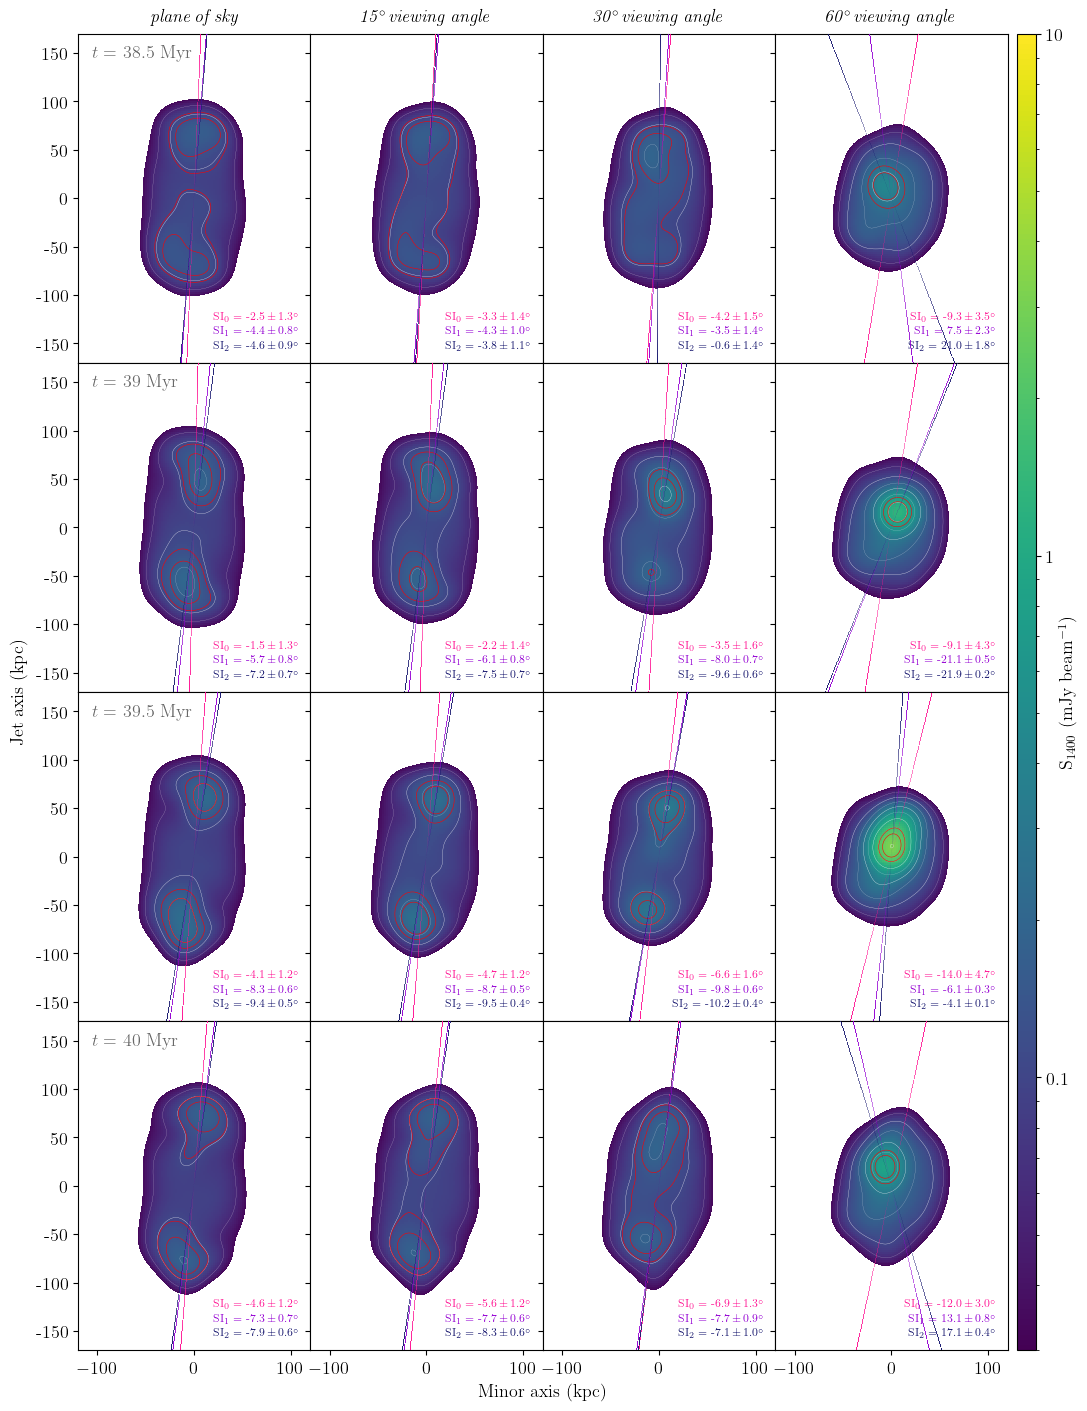

In [2163]:
fig = symmetry_plotter(foldername, filenames, grid_lim_x, grid_lim_y, 0.4, freq='1400MHz')

In [2137]:
fig.savefig('2myr_stats_z=0.4.pdf')

In [2141]:
fig.savefig('10myr_stats_z=0.4.pdf')

In [2145]:
fig.savefig('50myr_stats_z=0.4.pdf')

In [2148]:
fig.savefig('straight_stats_z=0.4.pdf')

#### Summary statistics

In [3]:
def summary_statistics(filenames, redshift):

    # create dataframe
    tf = pd.DataFrame(columns=['\\begin{tabular}{lccccc}', '', '', '', '', '', '', '', '', '', '', '\hline'])
    tf.loc[0] = ['Simulation', '&', 'Incl. Angle', '&', '\multicolumn{2}{c}{Jet Signatures}', '', '', '&', \
                                '\multicolumn{2}{c}{$\Delta$ Symmetry Axis}', '', '', '\\\\']
    tf.loc[1] = ['', '&', '(deg)', '&', 'LOFAR-LoTTS', '&', 'MeerKAT-MIGHTEE', '&', 'LOFAR-LoTTS (deg)', \
                                '&', 'MeerKAT-MIGHTEE (deg)', '\\\\\hline']
    
    # define confidence level
    crit_angle, sigma = 0.5, 2.
    
    # define inclination angles
    inc_angles = [0, 15, 30, 60]
    inc_weigths = np.zeros(len(inc_angles))
    for j in range(0, len(inc_angles)):
        if j < len(inc_angles) - 1:
            inc_weigths[j] = np.sin(inc_angles[j+1]*np.pi/180.) - np.sin(inc_angles[j]*np.pi/180.)
        else:
            inc_weigths[j] = 1 - np.sin(inc_angles[j]*np.pi/180.)
    inc_weigths = inc_weigths/np.sum(inc_weigths)
    
    # add processed data to dataframe
    for i in range(0, len(filenames)):

        if filenames[i] == 'straight':
            norm_color = 'purple'
            error_color = 'black'
        else:
            norm_color = 'black'
            error_color = 'purple'        

        df = pd.read_csv('{:}_150MHz_z={:.2f}.csv'.format(filenames[i], redshift), header=0, index_col=0)
        hf = pd.read_csv('{:}_1400MHz_z={:.2f}.csv'.format(filenames[i], redshift), header=0, index_col=0)
        kf = pd.read_csv('{:}_k150MHz_z={:.2f}.csv'.format(filenames[i], redshift), header=0, index_col=0)
        lf = pd.read_csv('{:}_k1400MHz_z={:.2f}.csv'.format(filenames[i], redshift), header=0, index_col=0)

        # combine Krause et al. (2019) classifications
        k_150_text = []
        k_150_prob = np.zeros(len(kf.index))
        for a in range(0, len(kf.index)):
            string = ''
            k_150_prob[a] = 1
            if kf.iloc[a,0] == 1:
                string = string + 'C'
            elif kf.iloc[a,0] >= 0.5:
                string = string + 'c'
            if kf.iloc[a,1] == 1:
                string = string + 'E'
            elif kf.iloc[a,1] >= 0.5:
                string = string + 'e'
            if kf.iloc[a,2] == 1:
                string = string + 'R'
            elif kf.iloc[a,2] >= 0.5:
                string = string + 'r'
            if kf.iloc[a,3] == 1:
                string = string + 'S'
            elif kf.iloc[a,3] >= 0.5:
                string = string + 's'
            if string == '':
                string = '--'
                k_150_prob[a] = 0
            if len(string) == 1:
                k_150_prob[a] = 0
            k_150_text.append(string)
        k_1400_text = []
        k_1400_prob = np.zeros(len(lf.index))
        for a in range(0, len(lf.index)):
            string = ''
            k_1400_prob[a] = 1
            if lf.iloc[a,0] == 1:
                string = string + 'C'
            elif lf.iloc[a,0] >= 0.5:
                string = string + 'c'
            if lf.iloc[a,1] == 1:
                string = string + 'E'
            elif lf.iloc[a,1] >= 0.5:
                string = string + 'e'
            if lf.iloc[a,2] == 1:
                string = string + 'R'
            elif lf.iloc[a,2] >= 0.5:
                string = string + 'r'
            if lf.iloc[a,3] == 1:
                string = string + 'S'
            elif lf.iloc[a,3] >= 0.5:
                string = string + 's'
            if string == '':
                string = '--'
                k_1400_prob[a] = 0
            if len(string) == 1:
                k_1400_prob[a] = 0
            k_1400_text.append(string)
        
        # calculate SI statistics for 150 MHz image
        SI_150_text = []
        SI_150_prob = np.zeros(len(df.index))
        for a in range(0, len(df.index)):
            comp1, dcomp1 = np.abs(df.iloc[a,0] - df.iloc[a,2]), np.sqrt(df.iloc[a,1]**2 + df.iloc[a,3]**2)
            comp2, dcomp2 = np.abs(df.iloc[a,2] - df.iloc[a,4]), np.sqrt(df.iloc[a,3]**2 + df.iloc[a,5]**2)
            comp3, dcomp3 = np.abs(df.iloc[a,4] - df.iloc[a,0]), np.sqrt(df.iloc[a,5]**2 + df.iloc[a,1]**2)
            if (comp1 - crit_angle)/dcomp1 > (comp2 - crit_angle)/dcomp2 and (comp1 - crit_angle)/dcomp1 > (comp3 - crit_angle)/dcomp3:
                if (comp1 - crit_angle)/dcomp1 >= sigma:
                    SI_150_prob[a] = 1
                    SI_150_text.append('${{\color{{{:}}}{:.1f}_{{({:.1f})}}}}$'.format(norm_color, comp1, dcomp1))   
                else:
                    SI_150_text.append('${{\color{{{:}}}{:.1f}_{{({:.1f})}}}}$'.format(error_color, comp1, dcomp1))   
            elif (comp2 - crit_angle)/dcomp2 > (comp3 - crit_angle)/dcomp3:
                if (comp2 - crit_angle)/dcomp2 >= sigma:
                    SI_150_prob[a] = 1
                    SI_150_text.append('${{\color{{{:}}}{:.1f}_{{({:.1f})}}}}$'.format(norm_color, comp2, dcomp2))   
                else:
                    SI_150_text.append('${{\color{{{:}}}{:.1f}_{{({:.1f})}}}}$'.format(error_color, comp2, dcomp2))   
            else:
                if (comp3 - crit_angle)/dcomp3 >= sigma:
                    SI_150_prob[a] = 1
                    SI_150_text.append('${{\color{{{:}}}{:.1f}_{{({:.1f})}}}}$'.format(norm_color, comp3, dcomp3))   
                else:
                    SI_150_text.append('${{\color{{{:}}}{:.1f}_{{({:.1f})}}}}$'.format(error_color, comp3, dcomp3))   
        
        # calculate SI statistics for 1400 MHz image
        SI_1400_text = []
        SI_1400_prob = np.zeros(len(hf.index))
        for a in range(0, len(hf.index)):
            comp1, dcomp1 = np.abs(hf.iloc[a,0] - hf.iloc[a,2]), np.sqrt(hf.iloc[a,1]**2 + hf.iloc[a,3]**2)
            comp2, dcomp2 = np.abs(hf.iloc[a,2] - hf.iloc[a,4]), np.sqrt(hf.iloc[a,3]**2 + hf.iloc[a,5]**2)
            comp3, dcomp3 = np.abs(hf.iloc[a,4] - hf.iloc[a,0]), np.sqrt(hf.iloc[a,5]**2 + hf.iloc[a,1]**2)
            if (comp1 - crit_angle)/dcomp1 > (comp2 - crit_angle)/dcomp2 and (comp1 - crit_angle)/dcomp1 > (comp3 - crit_angle)/dcomp3:
                if (comp1 - crit_angle)/dcomp1 >= sigma:
                    SI_1400_prob[a] = 1
                    SI_1400_text.append('${{\color{{{:}}}{:.1f}_{{({:.1f})}}}}$'.format(norm_color, comp1, dcomp1))   
                else:
                    SI_1400_text.append('${{\color{{{:}}}{:.1f}_{{({:.1f})}}}}$'.format(error_color, comp1, dcomp1))   
            elif (comp2 - crit_angle)/dcomp2 > (comp3 - crit_angle)/dcomp3:
                if (comp2 - crit_angle)/dcomp2 >= sigma:
                    SI_1400_prob[a] = 1
                    SI_1400_text.append('${{\color{{{:}}}{:.1f}_{{({:.1f})}}}}$'.format(norm_color, comp2, dcomp2))   
                else:
                    SI_1400_text.append('${{\color{{{:}}}{:.1f}_{{({:.1f})}}}}$'.format(error_color, comp2, dcomp2))   
            else:
                if (comp3 - crit_angle)/dcomp3 >= sigma:
                    SI_1400_prob[a] = 1
                    SI_1400_text.append('${{\color{{{:}}}{:.1f}_{{({:.1f})}}}}$'.format(norm_color, comp3, dcomp3))   
                else:
                    SI_1400_text.append('${{\color{{{:}}}{:.1f}_{{({:.1f})}}}}$'.format(error_color, comp3, dcomp3))    
                    
        # add each inclination angle to dataframe
        if filenames[i] == 'straight':
            kp, dp, hp, ap = 0, 0, 0, 0
            for j in range(0, len(inc_angles)):
                if j == 0:
                    name = '\multirow{4}{*}{Non-precessing}'
                else:
                    name = ''
                tf.loc[len(tf.index)] = [name, '&', '{:0d}'.format(inc_angles[j]), '&', '{:}'.format(k_150_text[j]), '&', \
                                    '{:}'.format(k_1400_text[j]), '&', '{:}'.format(SI_150_text[j]), '&', \
                                    '{:}'.format(SI_1400_text[j]), '\\\\']

                # calculate weighted probability
                kp = kp + np.sum(k_150_prob[j::len(inc_angles)])/len(k_150_prob[j::len(inc_angles)])*inc_weigths[j]
                ap = ap + np.sum(k_1400_prob[j::len(inc_angles)])/len(k_1400_prob[j::len(inc_angles)])*inc_weigths[j]
                dp = dp + np.sum(SI_150_prob[j::len(inc_angles)])/len(SI_150_prob[j::len(inc_angles)])*inc_weigths[j]
                hp = hp + np.sum(SI_1400_prob[j::len(inc_angles)])/len(SI_1400_prob[j::len(inc_angles)])*inc_weigths[j]
            
            tf.loc[len(tf.index)] = ['\hline\multicolumn{2}{c}{Probability}', '', '', '&', '{:.2f}'.format(kp), '&', '{:.2f}'.format(ap), \
                                    '&', '{:.2f}'.format(dp), '&', '{:.2f}'.format(hp), '\\\\\hline']
        elif filenames[i] == '50_myr':
            kp, dp, hp, ap = 0, 0, 0, 0
            for j in range(0, len(inc_angles)):
                if j == 0:
                    name = '\multirow{4}{*}{50\,Myr period}'             
                else:
                    name = ''
                tf.loc[len(tf.index)] = [name, '&', '{:0d}'.format(inc_angles[j]), '&', \
                                    '{:}, {:}'.format(k_150_text[j], k_150_text[4+j]), '&', \
                                    '{:}, {:}'.format(k_1400_text[j], k_1400_text[4+j]), '&', \
                                    '\scriptsize{:}, {:}'.format(SI_150_text[j], SI_150_text[4+j]), '&', \
                                    '\scriptsize{:}, {:}'.format(SI_1400_text[j], SI_1400_text[4+j]), '\\\\']
       
                # calculate weighted probability
                kp = kp + np.sum(k_150_prob[j::len(inc_angles)])/len(k_150_prob[j::len(inc_angles)])*inc_weigths[j]
                ap = ap + np.sum(k_1400_prob[j::len(inc_angles)])/len(k_1400_prob[j::len(inc_angles)])*inc_weigths[j]
                dp = dp + np.sum(SI_150_prob[j::len(inc_angles)])/len(SI_150_prob[j::len(inc_angles)])*inc_weigths[j]
                hp = hp + np.sum(SI_1400_prob[j::len(inc_angles)])/len(SI_1400_prob[j::len(inc_angles)])*inc_weigths[j]
            
            tf.loc[len(tf.index)] = ['\hline\multicolumn{2}{c}{Probability}', '', '', '&', '{:.2f}'.format(kp), '&', '{:.2f}'.format(ap), \
                                    '&', '{:.2f}'.format(dp), '&', '{:.2f}'.format(hp), '\\\\\hline']
        else:
            kp, dp, hp, ap = 0, 0, 0, 0
            for j in range(0, len(inc_angles)):
                if j == 0:
                    if filenames[i] == '2_myr':
                        name = '\multirow{4}{*}{2\,Myr period}'
                    else:
                        name = '\multirow{4}{*}{10\,Myr period}'             
                else:
                    name = ''
                tf.loc[len(tf.index)] = [name, '&', '{:0d}'.format(inc_angles[j]), '&', \
                                    '{:}, {:}, {:}, {:}'.format(k_150_text[j], k_150_text[4+j], k_150_text[8+j], k_150_text[12+j]), '&', \
                                    '{:}, {:}, {:}, {:}'.format(k_1400_text[j], k_1400_text[4+j], k_1400_text[8+j], k_1400_text[12+j]), '&', \
                                    '\scriptsize{:}, {:}, {:}, {:}'.format(SI_150_text[j], SI_150_text[4+j], SI_150_text[8+j], SI_150_text[12+j]), '&', \
                                    '\scriptsize{:}, {:}, {:}, {:}'.format(SI_1400_text[j], SI_1400_text[4+j], SI_1400_text[8+j], SI_1400_text[12+j]), '\\\\']
       
                # calculate weighted probability
                kp = kp + np.sum(k_150_prob[j::len(inc_angles)])/len(k_150_prob[j::len(inc_angles)])*inc_weigths[j]
                ap = ap + np.sum(k_1400_prob[j::len(inc_angles)])/len(k_1400_prob[j::len(inc_angles)])*inc_weigths[j]
                dp = dp + np.sum(SI_150_prob[j::len(inc_angles)])/len(SI_150_prob[j::len(inc_angles)])*inc_weigths[j]
                hp = hp + np.sum(SI_1400_prob[j::len(inc_angles)])/len(SI_1400_prob[j::len(inc_angles)])*inc_weigths[j]
            
            tf.loc[len(tf.index)] = ['\hline\multicolumn{2}{c}{Probability}', '', '', '&', '{:.2f}'.format(kp), '&', '{:.2f}'.format(ap), \
                                    '&', '{:.2f}'.format(dp), '&', '{:.2f}'.format(hp), '\\\\\hline']

    tf.loc[len(tf.index)] = ['', '', '', '', '', '', '', '', '', '', '', '\end{tabular}']
    tf.to_csv('summary_z={:.2f}.csv'.format(redshift), index=False)

In [4]:
filenames = ['straight', '50_myr', '10_myr', '2_myr']

In [7]:
summary_statistics(filenames, 0.4)

#### Double-blind images

In [24]:
import random

def double_blind(foldernames, filenames, redshifts, nvars=1, seed=0, freq='150MHz', decode=False):

    # define custom colormaps
    cmap = copy(plt.get_cmap('viridis'))
    #cmap.set_under('white', 1.0)  # 1.0 represents not transparent
    cmap2 = copy(plt.get_cmap('plasma_r'))
    cmap2.set_under('white', 1.0)  # 1.0 represents not transparent
    
    rc('text', usetex=True)
    rc('font', size=13)
    rc('legend', fontsize=13)
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    
    # define beam properties
    beam_x, beam_y, bpa = 5., 5., 0.
    dLs = (cosmo.luminosity_distance(redshifts).to(u.kpc)).value
    warnings.filterwarnings('ignore')

    # calculate number of images
    nfilenames = np.sum(len(x) for x in filenames)
    nimages = nfilenames*len(redshifts)*nvars

    fig, axs = plt.subplots((nimages + 3)//4, 4, figsize=(8, (nimages + 3)//4 * 2))
    fig.subplots_adjust(hspace=0, wspace=0)

    # calculate random ordering of images
    random.seed(seed)
    rand_index = random.sample(range(nimages), nimages)

    # create datafile for decode
    df = pd.DataFrame(columns=['index', 'simulation', 'inclination', 'period', 'redshift'])
    
    for i in range(0, nimages):
        # decode random index
        x_idx = rand_index[i]//(len(redshifts)*nvars)
        r_idx = (rand_index[i] - x_idx*(len(redshifts)*nvars))//nvars
        # find folder and filename number
        o_idx, f_idx = 0, 0
        for j in range(1, nfilenames):
            if j <= x_idx:
                f_idx = f_idx + 1
                try:
                    filenames[o_idx][f_idx] # test to see if reached end of sublist
                except:
                    o_idx = o_idx + 1
                    f_idx = 0
        
        # read in primary frequency radio image
        if freq == '150MHz':
            sim = np.load(foldernames[o_idx]+filenames[o_idx][f_idx])
            rms = 0.1
        else:
            sim = np.load(foldernames[o_idx]+filenames[o_idx][f_idx].replace('0.15 GHz', '1.4 GHz'))
            rms = 0.01
        x = np.linspace(grid_lim_x[0], grid_lim_x[-1], len(sim[:,0]), endpoint=True)
        y = np.linspace(grid_lim_y[0], grid_lim_y[-1], len(sim[0,:]), endpoint=True)

        # convolve primary frequency image with gaussian beam for redshift (cannot be less than z=0.05)
        gauss_kernel = Gaussian2DKernel(x_stddev=beam_x*(dLs[r_idx]/(1 + redshifts[r_idx])**2)/(3600*180/np.pi)/(2*np.sqrt(2*np.log(2)))/(x[1] - x[0]), \
                                    y_stddev=beam_y*(dLs[r_idx]/(1 + redshifts[r_idx])**2)/(3600*180/np.pi)/(2*np.sqrt(2*np.log(2)))/(y[1] - y[0]), \
                                    theta=bpa*np.pi/180.) # pixels
        surface_brightness = np.zeros((len(sim[0,:]),len(sim[0,:])))
        surface_brightness[:,(len(sim[0,:]) - len(sim[:,0]))//2:(len(sim[0,:]) - len(sim[:,0]))//2 + len(sim[:,0])] \
                        = np.transpose(convolve(sim[:,:], gauss_kernel)/(1 + redshifts[r_idx])**2)

        # widen straight jet images
        if foldernames[o_idx] == 'angles_ages/straight/':
            surface_brightness = ndimage.zoom(np.nan_to_num(surface_brightness, copy=True, nan=0.), zoom=[1, 1.5], order=3)
            surface_brightness = surface_brightness[:,(len(surface_brightness[0,:]) - len(surface_brightness[:,0]))//2: \
                        (len(surface_brightness[0,:]) - len(surface_brightness[:,0]))//2 + len(surface_brightness[:,0])]
        
        # rotate image
        angle = np.random.rand()*360
        rot_img = ndimage.rotate(np.nan_to_num(surface_brightness, copy=True, nan=0.), angle, reshape=False, order=3)

        # add random noise to image
        x_stddev = gauss_kernel.__dict__['_model'].__dict__['x_stddev'].value
        y_stddev = gauss_kernel.__dict__['_model'].__dict__['y_stddev'].value
        pixels_per_beam = np.pi*x_stddev*y_stddev*(2*np.log(2))
        nse_img = convolve(np.random.normal(loc=0., scale=rms*np.sqrt(pixels_per_beam), \
                                 size=(len(rot_img[:,0]), len(rot_img[0,:]))), gauss_kernel) 
        
        surface_brightness = (rot_img + nse_img)
        cropped = surface_brightness.copy()
        cropped[cropped <= 0.1*rms] = 0

        if foldernames[o_idx] == 'angles_ages/straight/':
            X, Y = np.meshgrid(y/280., y/280.)
        elif foldernames[o_idx] == 'angles_ages/50_myr/':
            X, Y = np.meshgrid(y/170., y/170.)
        else:
            X, Y = np.meshgrid(y/150., y/150.)
            
        # create plot of simulation with symmetry axes and jet signatures
        h = axs[i//4,i%4].pcolormesh(X, Y, cropped, cmap=cmap, norm=LogNorm(vmin=3*rms, vmax=1000*rms), rasterized=True)

        axs[i//4,i%4].contourf(X, Y, surface_brightness, levels=rms*10**np.array([-2,0.5]), colors='w', linewidths=0.2)
        axs[i//4,i%4].contour(X, Y, surface_brightness, levels=rms*10**np.arange(0,10,0.5), colors='w', linewidths=0.2)
        axs[i//4,i%4].contour(X, Y, surface_brightness, levels=rms*10**np.arange(0.25,10,0.5), colors='w', linewidths=0.1)

        # add plot number
        if decode == False:
            axs[i//4,i%4].text(-0.9, -0.9, r'{:0d}\,'.format(i + 1), ha='left', c='indigo', fontsize=10)
        else:
            axs[i//4,i%4].text(-0.9, -0.9, r'{:}, {:g} deg, z = {:.2f}\,'.format(filenames[o_idx][f_idx].split('.', 1)[0], \
                    float(filenames[o_idx][f_idx].split('angle', 1)[1].split('.freq', 1)[0]), redshifts[r_idx]), ha='left', c='indigo', fontsize=8)            

        # add to decode file
        df.loc[i] = [i + 1, filenames[o_idx][f_idx].split('.', 1)[0], float(filenames[o_idx][f_idx].split('angle', 1)[1].split('.freq', 1)[0]), \
                    f_idx//4 + 1, redshifts[r_idx]]
        
        # set axes limits and tick marks
        axs[i//4,i%4].set_aspect(1)
        axs[i//4,i%4].set_xlim([-1, 1])
        axs[i//4,i%4].set_ylim([-1, 1])
        axs[i//4,i%4].set_xticklabels([])
        axs[i//4,i%4].set_yticklabels([])

    fig.tight_layout()
    if freq == '150MHz':
        df.to_csv('150MHz_decode.csv', index=False)
    else:
        df.to_csv('1400MHz_decode.csv', index=False)        

    return fig

In [18]:
foldernames = ['angles_ages/2_myr/', 'angles_ages/10_myr/', 'angles_ages/50_myr/', 'angles_ages/straight/']
filenames = [['2 Myr.age38.5.angle0.frequency0.15 GHz.npy', '2 Myr.age38.5.angle15.frequency0.15 GHz.npy', \
             '2 Myr.age38.5.angle30.frequency0.15 GHz.npy', '2 Myr.age38.5.angle60.frequency0.15 GHz.npy', \
             '2 Myr.age39.angle0.frequency0.15 GHz.npy', '2 Myr.age39.angle15.frequency0.15 GHz.npy', \
             '2 Myr.age39.angle30.frequency0.15 GHz.npy', '2 Myr.age39.angle60.frequency0.15 GHz.npy', \
             '2 Myr.age39.5.angle0.frequency0.15 GHz.npy', '2 Myr.age39.5.angle15.frequency0.15 GHz.npy', \
             '2 Myr.age39.5.angle30.frequency0.15 GHz.npy', '2 Myr.age39.5.angle60.frequency0.15 GHz.npy', \
             '2 Myr.age40.0.angle0.frequency0.15 GHz.npy', '2 Myr.age40.0.angle15.frequency0.15 GHz.npy', \
             '2 Myr.age40.0.angle30.frequency0.15 GHz.npy', '2 Myr.age40.0.angle60.frequency0.15 GHz.npy'],
             ['10 Myr.age32.5.angle0.frequency0.15 GHz.npy', '10 Myr.age32.5.angle15.frequency0.15 GHz.npy', \
             '10 Myr.age32.5.angle30.frequency0.15 GHz.npy', '10 Myr.age32.5.angle60.frequency0.15 GHz.npy', \
             '10 Myr.age35.angle0.frequency0.15 GHz.npy', '10 Myr.age35.angle15.frequency0.15 GHz.npy', \
             '10 Myr.age35.angle30.frequency0.15 GHz.npy', '10 Myr.age35.angle60.frequency0.15 GHz.npy', \
             '10 Myr.age37.5.angle0.frequency0.15 GHz.npy', '10 Myr.age37.5.angle15.frequency0.15 GHz.npy', \
             '10 Myr.age37.5.angle30.frequency0.15 GHz.npy', '10 Myr.age37.5.angle60.frequency0.15 GHz.npy', \
             '10 Myr.age40.angle0.frequency0.15 GHz.npy', '10 Myr.age40.angle15.frequency0.15 GHz.npy', \
             '10 Myr.age40.angle30.frequency0.15 GHz.npy', '10 Myr.age40.angle60.frequency0.15 GHz.npy'],
             ['50 Myr.age25.0.angle0.frequency0.15 GHz.npy', '50 Myr.age25.0.angle15.frequency0.15 GHz.npy', \
             '50 Myr.age25.0.angle30.frequency0.15 GHz.npy', '50 Myr.age25.0.angle60.frequency0.15 GHz.npy', \
             '50 Myr.age37.5.angle0.frequency0.15 GHz.npy', '50 Myr.age37.5.angle15.frequency0.15 GHz.npy', \
             '50 Myr.age37.5.angle30.frequency0.15 GHz.npy', '50 Myr.age37.5.angle60.frequency0.15 GHz.npy'],
             ['Straight Jet.age40.angle0.frequency0.15 GHz.npy', 'Straight Jet.age40.angle15.frequency0.15 GHz.npy', \
             'Straight Jet.age40.angle30.frequency0.15 GHz.npy', 'Straight Jet.age40.angle60.frequency0.15 GHz.npy']]
redshifts = [0.05, 0.2, 0.4]

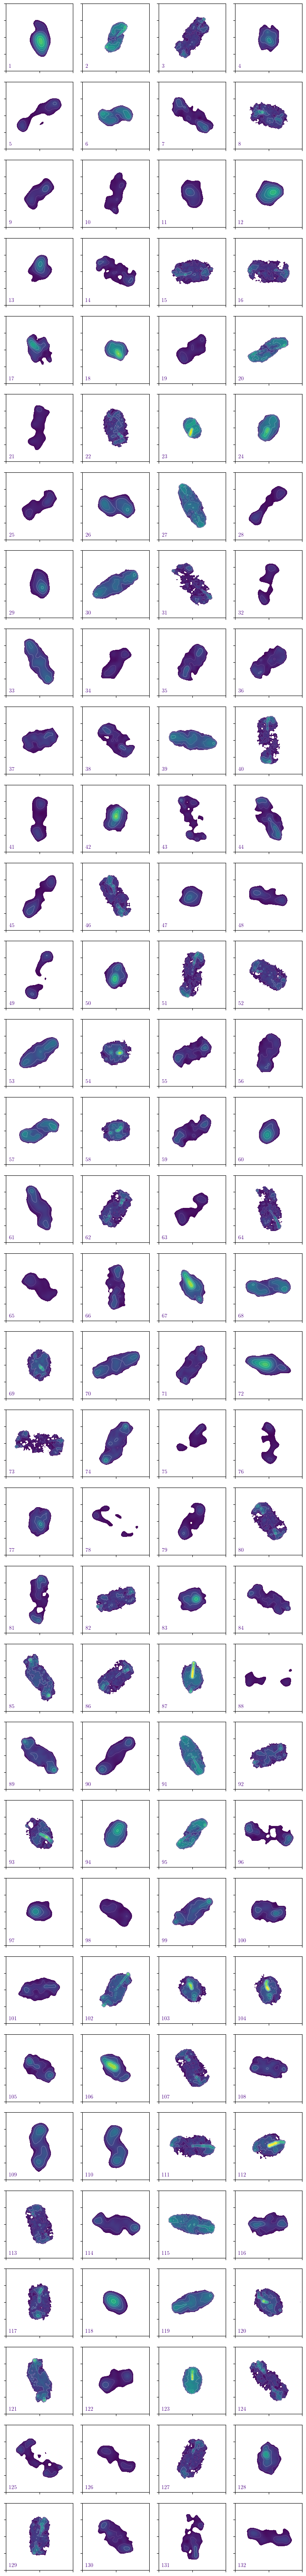

In [25]:
fig = double_blind(foldernames, filenames, redshifts, nvars=1, seed=150, freq='150MHz', decode=False)

In [2389]:
fig.savefig('double_blind_150_decode.pdf')

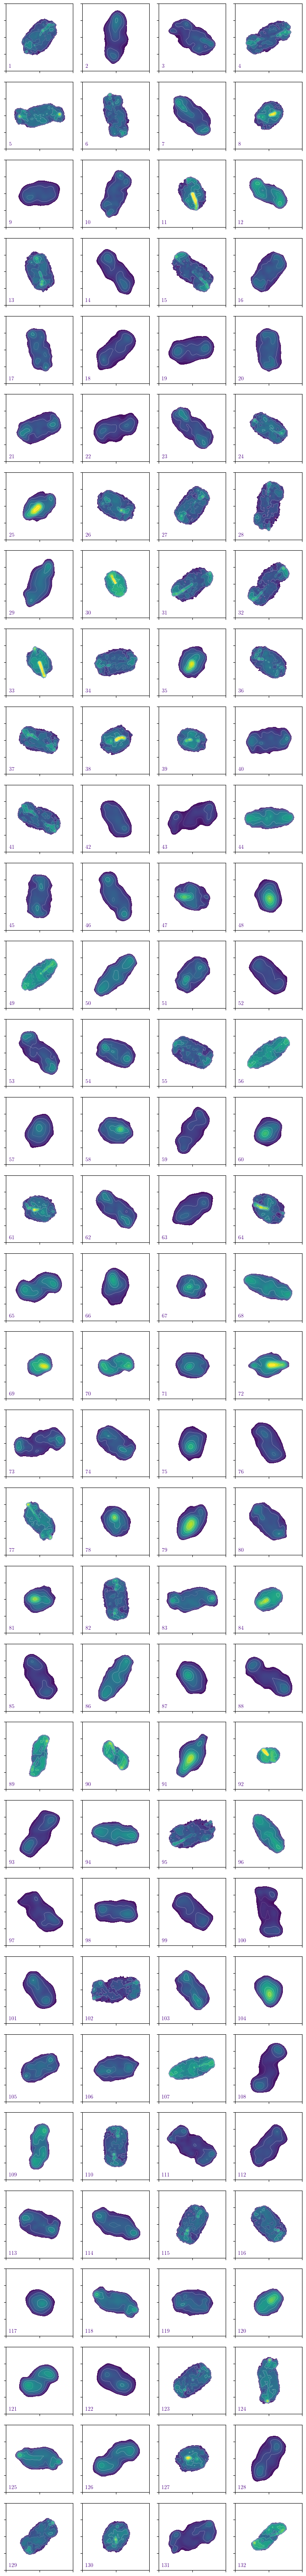

In [26]:
fig = double_blind(foldernames, filenames, redshifts, nvars=1, seed=1400, freq='1400MHz', decode=False)

In [16]:
fig.savefig('double_blind_1400.pdf')

In [66]:
def double_blind_statistics(redshifts=[0.05, 0.2, 0.4]):

    df = pd.read_csv('150MHz_decode_ZS.csv')
    hf = pd.read_csv('1400MHz_decode_ZS.csv')

    simulations = ['straight', '50_myr', '10_myr', '2_myr']
    s_code = ['Straight Jet', '50 Myr', '10 Myr', '2 Myr']
    inclinations = [0, 15, 30, 60]

    for f in range(0, 2):
        for i in range(0, len(simulations)):
            for j in range(0, len(redshifts)):
                # create file for signatures
                kf = pd.DataFrame(columns=['C', 'E', 'R', 'S'])
                count = 0

                if f == 0:
                    tf = df[(df['simulation'] == s_code[i]) & (df['redshift'] == redshifts[j])]
                else:
                    tf = hf[(hf['simulation'] == s_code[i]) & (hf['redshift'] == redshifts[j])]                    
                for k in range(0, len(inclinations)):
                    for l in range(0, 4):
                        try:
                            uf = tf[(tf['inclination'] == inclinations[k]) & (tf['period'] == l + 1)]
                            kf.loc[count] = [uf['C'].values[0], uf['E'].values[0], uf['R'].values[0], uf['S'].values[0]]
                            count = count + 1
                        except:
                            pass
                if f == 0:
                    kf.to_csv(simulations[i]+'_k150MHz_z={:.2f}.csv'.format(redshifts[j]))
                else:
                    kf.to_csv(simulations[i]+'_k1400MHz_z={:.2f}.csv'.format(redshifts[j]))   

In [67]:
double_blind_statistics()